In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import orbipy as op
import math

from scipy.interpolate import interp2d
from scipy.optimize import fminbound #Минимизирует угол

In [2]:
mp = pd.read_csv('cropped_map_SE_L1_qh.csv')
mp.columns#как далека точка dk4 

Index(['x', 'z', 'vy', 'J', 'dk2', 'dk4', 'dk8'], dtype='object')

In [137]:
%matplotlib inline

<IPython.core.display.Javascript object>


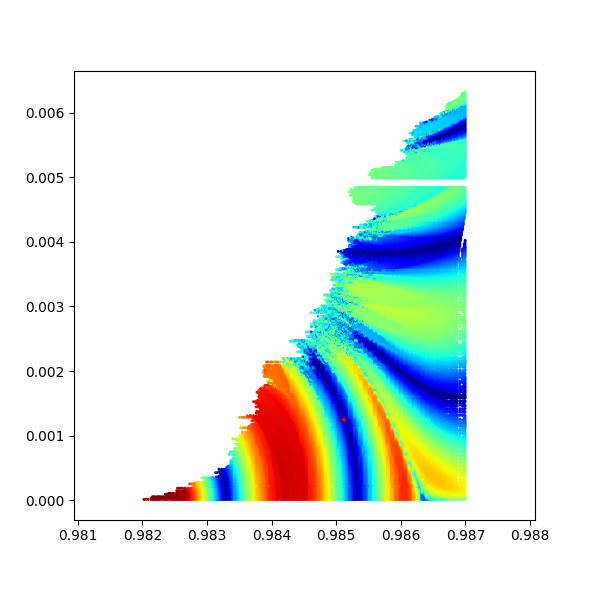

In [125]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(mp.x, mp.z, c=mp.dk8, s=1, cmap='jet')

ax.scatter(0.98511,  0.00125, c='r', s=3)
ax.axis('equal');

# ax.set_xlim(0.982, 0.984)
# ax.set_ylim(0, 0.001)

### выбор точки на карте, в качестве начального приближения

In [151]:
arr = mp.to_numpy()

In [152]:
def nearest_xz(x, z):
    return np.argmin(np.linalg.norm(arr[:,:2] - np.array([x, z]), axis=1))

def nearest(xz):
    return np.argmin(np.linalg.norm(arr[:,:2] - xz, axis=1))

In [153]:
ind2 = nearest_xz(0.9832176404884675,  0.00041622093911139094)
ind2

51785

In [154]:
arr[ind2]

array([9.83224135e-01, 4.27807487e-04, 3.44093835e-02, 3.00001515e+00,
       7.08209378e-02, 1.37875048e-03, 2.27768155e-03])

In [155]:
a = arr[arr[:,1]==arr[ind2,1]]
a = a[np.logical_not(np.isnan(a[:,-2]))]

In [156]:
ind = np.argmin(a[:,-2])
ind

218

In [157]:
a[ind]

array([9.83224135e-01, 4.27807487e-04, 3.44093835e-02, 3.00001515e+00,
       7.08209378e-02, 1.37875048e-03, 2.27768155e-03])

In [158]:
ev_y0   = op.eventY()
ev_y0_2   = op.eventY(count=2)

In [159]:
model = op.crtbp3_model()
stmmodel = op.crtbp3_model(stm=True)
plotter = op.plotter.from_model(model, length_units='Mm')
scale = plotter.scaler

In [160]:
s = model.get_zero_state()
s[[0, 2, 4]] = a[ind, :3]


jc = a[ind, 3]
left = op.eventSPL(model, jc-1e-7, accurate=False)
right = op.eventSPL(model, jc-1e-7, left=False, accurate=False)

corr = op.border_correction(model, op.y_direction(), left, right, maxt=1000., dv0=0.01)
corr_unst = op.border_correction(model, op.unstable_direction_stm(stmmodel), 
                            [left], [right],
                            maxt=10000)   

sk = op.simple_station_keeping(model, corr, corr_unst, rev=ev_y0, verbose=True)
df = sk.prop(0.0, s, N=8)

Simple station-keeping: 0 1 2 3 4 5 6 7 


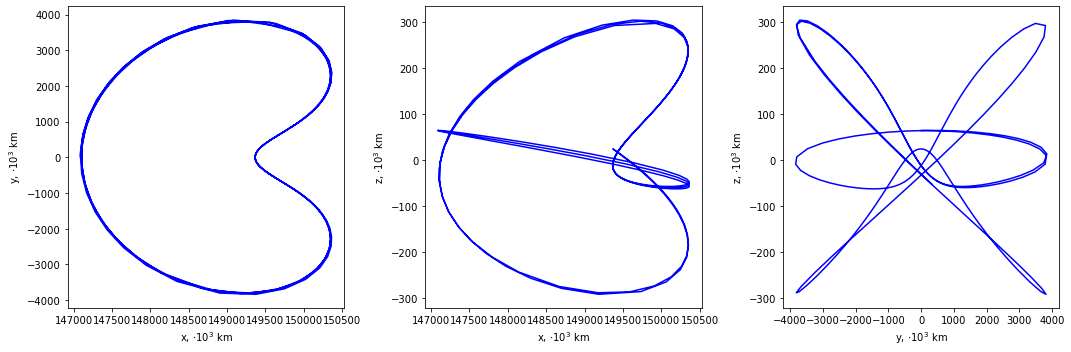

In [162]:
ax = plotter.plot_proj(df)

In [163]:
df.to_numpy()[-1]

array([ 2.16024743e+01,  9.83374816e-01,  2.19193300e-03, -3.50877026e-04,
        1.80941311e-03,  3.40622892e-02, -2.26636904e-03])

### создание модели и сам алгоритм

In [164]:
#Здесь я только сохранил исходную точку
model = op.crtbp3_model()
stmmodel = op.crtbp3_model(stm=True)
plotter = op.plotter.from_model(model, length_units='Mm')
scale = plotter.scaler
history = np.zeros(3).reshape(1,3)
history[0][0] = a[ind,0]
history[0][1] = a[ind,1]
history[0][2] = a[ind,2]
det = op.event_detector(model, events=[op.eventY(count=10)])
#df, _ = det.prop(s, 0, 20)


In [166]:
# field-of-view angle
fov = -70

# crawler step size
r = 1000 / model.R # km

In [167]:
# количество полуоборотов
N = 8

In [168]:
s = model.get_zero_state()


In [169]:

s = model.get_zero_state()
s[[0,2,4]] = [a[ind,0], a[ind,1], a[ind,2]]
ev_y0   = op.eventY()
ev_y0_2   = op.eventY(count=2)
jc = a[ind, 3]
left = op.eventSPL(model, jc-1e-7, accurate=False)
right = op.eventSPL(model, jc-1e-7, left=False, accurate=False)

corr = op.border_correction(model, op.y_direction(), left, right, maxt=1000., dv0=0.01)
corr_unst = op.border_correction(model, op.unstable_direction_stm(stmmodel), 
                            [left], [right],
                            maxt=10000)  

sk = op.simple_station_keeping(model, corr, corr_unst, rev=ev_y0, verbose=True)
df = sk.prop(0.0, s, N=N)

Simple station-keeping: 0 1 2 3 4 5 6 7 


In [170]:
def f(a, s_prev):
    s = s_prev.copy()
    s[0] += r * math.cos(math.radians(a))
    s[2] += r * math.sin(math.radians(a))
    
    df = sk.prop(0.0, s, N=N)
    xf, zf = sk.evout[-1, [4,6]]
    return (s[0] - xf)**2 + (s[2] - zf)**2

history = [[a[ind,0], a[ind,1], a[ind,2], fov, f(fov, s)]]

i = 0
while i < 1000:
    fov = history[-1][3]
    s = model.get_zero_state()
    s[[0, 2, 4]] = history[-1][:3]
    
    result = fminbound(f, fov - 45, fov + 45, 
                    full_output=True, args=(s,), xtol=1e-1)
    fov = result[0]
    sn = s.copy()
    sn[0] += r * np.cos(np.radians(fov))
    sn[2] += r * np.sin(np.radians(fov))
    df = sk.prop(0, sn, N=1)
    if sn[2] <= 0:
        break
    history.append([sn[0], sn[2], df.iloc[0].vy, fov, result[1]])
    
    
    i += 1

Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-ke

Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-ke

Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-ke

In [171]:
history


[[0.9832241351529114,
  0.000427807486631016,
  0.03440938352900828,
  -70,
  3.956233257665441e-07],
 [0.9832281416523312,
  0.0004224567487929612,
  0.03440190599056769,
  -53.175043895526265,
  3.950684337563038e-07],
 [0.9832321288880481,
  0.000417091640746544,
  0.03439446303563229,
  -53.38104306584597,
  3.82070394508052e-07],
 [0.9832360957832706,
  0.00041171147575782066,
  0.0343870566856426,
  -53.597961349600205,
  3.6932555990333213e-07],
 [0.9832400419007005,
  0.0004063160526750545,
  0.0343796877752031,
  -53.81891974989763,
  3.568332891438402e-07],
 [0.9832439665686296,
  0.0004009050070590769,
  0.03437235757544321,
  -54.0463694901732,
  3.4459285254320245e-07],
 [0.9832478691004413,
  0.0003954779748617206,
  0.03436506738632644,
  -54.28041548325191,
  3.3260343103663667e-07],
 [0.9832517480698176,
  0.00039003407648012105,
  0.034357819884746094,
  -54.52878906490031,
  3.2086411912949534e-07],
 [0.9832556041869807,
  0.00038457396719212883,
  0.0343506137751846

Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 
Simple station-keeping: 0 1 2 3 4 5 6 7 


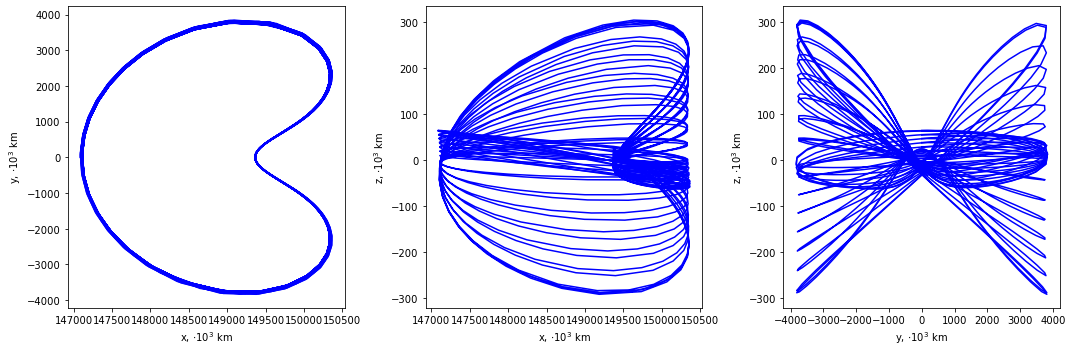

In [173]:
s = model.get_zero_state()
s[[0, 2, 4]] = history[0][:3]

df = sk.prop(0, s, N=N)

ax = plotter.plot_proj(df)
for x in history[1::10]:
    s[[0, 2, 4]] = x[:3]
    df = sk.prop(0, s, N=N)
    plotter.plot_proj(df, ax=ax)
    

In [174]:
arr = np.array(history)

In [175]:

plt.savefig("figure.png")

<Figure size 432x288 with 0 Axes>

(0.0, 0.001)

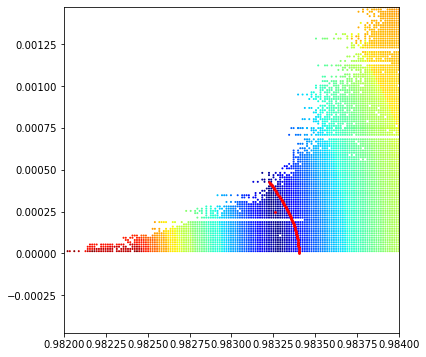

In [176]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(mp.x, mp.z, c=mp.dk4, s=1, cmap='jet')
ax.scatter(arr[:,0], arr[:,1], c='r', s=3)
ax.scatter(0.98326, 0.00025, c='r', s=3)
ax.axis('equal');

ax.set_xlim(0.982, 0.984)
ax.set_ylim(0, 0.001)

# сохранить arr

In [177]:
hist = np.array(history)

In [178]:
np.savetxt('qh_se_l1_2.csv', hist)